# Generalized Linear Models
Inheritance of eye color

In [1]:
import numpy as np                      # all of math 
from scipy import stats                 # statistical methods
import pandas as pd                     # for Dataframes
import statsmodels.api as sm            # contains GLM
import statsmodels.formula.api as smf   # same glm with patsy 
import patsy                            # handles formula strings
from matplotlib import pyplot as plt    # plotting methods
%matplotlib inline

c:\users\schal\appdata\local\programs\python\python37\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [5]:
# load the data
data = pd.read_csv('data/GaltonEyeColorHeredity.csv')
# eye color parents P: H = hazel, L = light, D = dark
# eye color grand-parents G: H = hazel, L = light, D = dark
# number of children (N) and number of children with light eyes (L)
print(data.head())
print('number of families: {}'.format(len(data)))

   PL  PH  PD  GL  GH  GD  N  L
0   2   0   0   4   0   0  6  6
1   2   0   0   4   0   0  6  6
2   2   0   0   4   0   0  6  6
3   2   0   0   4   0   0  6  5
4   2   0   0   4   0   0  7  7
number of families: 78


In [6]:
# create categories (combinatorics: parents 6, grandparents 15)
Pi = 100*data['PL']+10*data['PH']+data['PD']
data['PI'] = Pi
Gi = 100*data['GL']+10*data['GH']+data['GD']
data['GI'] = Gi
# choose relation of light eyed children as measure of interest (L/N) which follows Bernoulli distribution
data['Y'] = data['L']/data['N']
data['PI'] = data.PI.astype("category").cat.codes
data['GI'] = data.GI.astype("category").cat.codes
print(data.head())

   PL  PH  PD  GL  GH  GD  N  L  PI  GI         Y
0   2   0   0   4   0   0  6  6   5  11  1.000000
1   2   0   0   4   0   0  6  6   5  11  1.000000
2   2   0   0   4   0   0  6  6   5  11  1.000000
3   2   0   0   4   0   0  6  5   5  11  0.833333
4   2   0   0   4   0   0  7  7   5  11  1.000000


## Fit a GLM using only the data of the parents to predict the proportion of light-eyed children

In [7]:
# fit GLM based on only parents data with logit-link-function
p_fit = smf.glm(formula='Y ~ C(100*PL+10*PH+PD)', data=data, family = sm.families.Binomial(link=sm.families.links.logit)).fit()
print(p_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   78
Model:                            GLM   Df Residuals:                       72
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26.650
Date:                Mon, 18 May 2020   Deviance:                       14.006
Time:                        16:38:17   Pearson chi2:                     16.6
No. Iterations:                     6   Covariance Type:             nonrobust
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.1388      0.952     -1.196      0.232      -3

Detected and removed 2 outliers


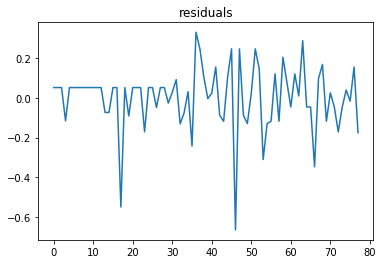

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   76
Model:                            GLM   Df Residuals:                       70
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.655
Date:                Mon, 18 May 2020   Deviance:                       9.3437
Time:                        16:40:44   Pearson chi2:                     9.26
No. Iterations:                     6   Covariance Type:             nonrobust
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.1388      0.952     -1.196      0.232      -3

In [8]:
# search for outliers and adapt model
residuals = np.abs(data['Y'] - p_fit.fittedvalues)
z = np.abs(stats.zscore(residuals,ddof=5))
threshold = 3
outliers = np.where(z > 3)
print('Detected and removed {} outliers'.format(len(outliers[0])))
data_pnew = data.drop(outliers[0])
plt.plot(np.asarray(data.index),data['Y'] - p_fit.fittedvalues)
plt.title('residuals')
plt.show();
p_fit = smf.glm(formula='Y ~ C(100*PL+10*PH+PD)', data=data_pnew, family = sm.families.Binomial(link=sm.families.links.logit)).fit()
print(p_fit.summary())

In [13]:
# predictions for all parent categories
parents = pd.DataFrame({'PL': [2,1,1,0,0,0],'PH': [0,1,0,2,0,1],'PD':[0,0,1,0,2,1]})
pred_p = p_fit.predict(parents)
print(pred_p)

0    0.968509
1    0.793710
2    0.546658
3    0.598214
4    0.242544
5    0.461386
dtype: float64


If both parents have light eyes, their children quite likely have them as well. It is unlikely that the children have light eyes, if one of the parents has dark eyes. Having hazel eyes also reduces the probability for the child having light eyes but not as much as dark eyes do.

| Parents | PL | PH | PD |
| --- | --- | --- | --- |
| PL | 0.97 | 0.79 | 0.55 |
| PH | 0.79 | 0.60 | 0.46 |
| PD | 0.55 | 0.46 | 0.24 |

## Fit a GLM using data from grandparents and parents to predict the proportion of light-eyed children

In [14]:
# fit GLM using parent and grandparent data
g_fit = smf.glm(formula='Y ~ C(100*PL+10*PH+PD) + C(100*GL+10*GH+GD)', data=data, family =sm.families.Binomial(link=sm.families.links.logit)).fit()
print(g_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   78
Model:                            GLM   Df Residuals:                       61
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25.962
Date:                Mon, 18 May 2020   Deviance:                       12.630
Time:                        16:48:26   Pearson chi2:                     13.7
No. Iterations:                     6   Covariance Type:             nonrobust
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.2391      2.314     -0.535      0.592      -5

In [15]:
# find and remove outliers and fit again
residuals = data['Y']-g_fit.fittedvalues
z = np.abs(stats.zscore(residuals,ddof=16))
threshold = 3
outliers = np.where(z > 3)
print('Detected and removed {} outliers'.format(len(outliers[0])))
data_gnew = data.drop(outliers[0])
g_fit = smf.glm(formula='Y ~ C(100*PL+10*PH+PD) + C(100*GL+10*GH+GD)', data=data_gnew, family =sm.families.Binomial(link=sm.families.links.logit)).fit()
print(g_fit.summary())

Detected and removed 2 outliers
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   76
Model:                            GLM   Df Residuals:                       59
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22.893
Date:                Mon, 18 May 2020   Deviance:                       7.8185
Time:                        16:49:17   Pearson chi2:                     7.70
No. Iterations:                     6   Covariance Type:             nonrobust
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.2773      2.3

This model has more degrees of freedom, thus per default fits the data better. Compared to the parent model, there are now coefficients with negative values. The coefficients related to the grandparents are smaller than those of the parents.

## Visually compare the two models with the data

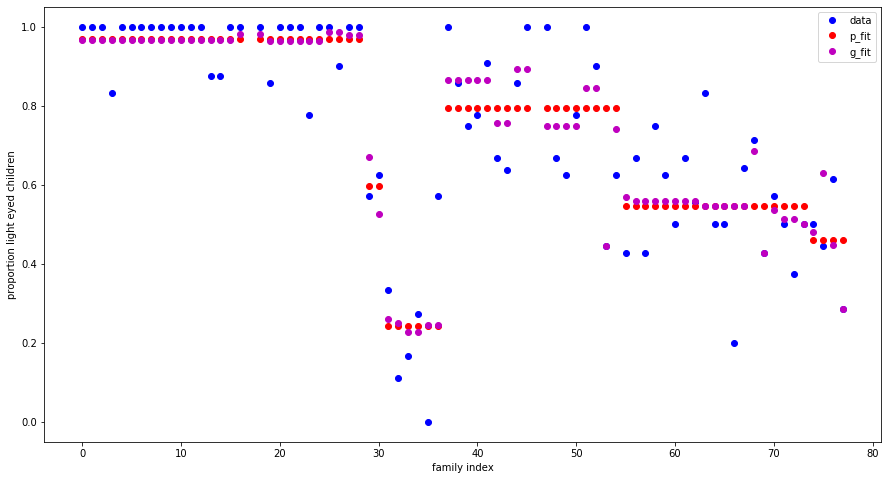

In [19]:
# plot the original data and the two fitted models
fig = plt.figure(figsize=(15,8))
plt.plot(np.asarray(data_pnew.index),data_pnew['Y'],'bo',label='data')
plt.plot(np.asarray(data_pnew.index),p_fit.fittedvalues,'ro',label='p_fit')
plt.plot(np.asarray(data_gnew.index),g_fit.fittedvalues,'mo',label='g_fit')
plt.legend()
plt.xlabel('family index')
plt.ylabel('proportion light eyed children')
plt.show()

Both models fit the data comparably well. The eye color of the grandparents adds additional information about the genes of the parents and thus allows for a better fit. Outliers that the model cannot account for can arise from chiasmas happening during meiosis, infidelity of the parents, or mistakes during data collection.